In [10]:
import pandas as pd
import numpy as np
# Load the data
data = pd.read_csv('bigdata.csv')

# Convert 'Date' to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Remove commas from numeric fields and convert them to float
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)
data['Vol.'] = data['Vol.'].apply(lambda x: (float(x.replace('M', '').replace(',', '')) * 1e6 )if isinstance(x, str) and 'M' in x else (float(x.replace('B', '').replace(',', '')) * 1e9) if isinstance(x, str) and 'B' in x else np.nan if x=='' else x)
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)

# Set 'Date' as the index
data.set_index('Date', inplace=True)

print(data.head())



               Price     Open      High       Low         Vol.  Change %
Date                                                                    
2024-08-30  25235.90  25249.7  25268.35  25199.40  638170000.0      0.33
2024-08-29  25151.95  25035.3  25192.90  24998.50  353990000.0      0.40
2024-08-28  25052.35  25030.8  25129.60  24964.65  220420000.0      0.14
2024-08-27  25017.75  25024.8  25073.10  24973.65  223350000.0      0.03
2024-08-26  25010.60  24906.1  25043.80  24874.70  210270000.0      0.76


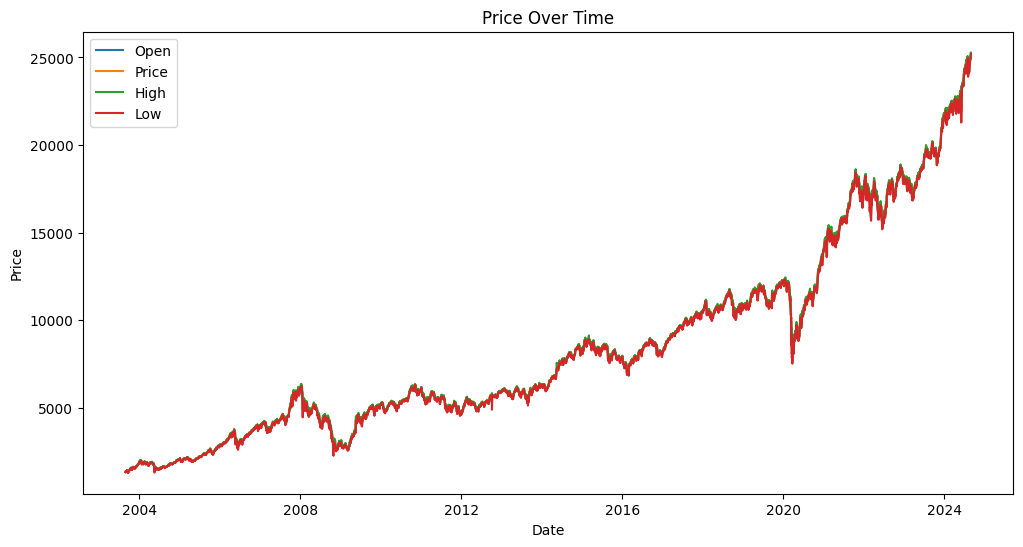

In [11]:
import matplotlib.pyplot as plt

# Plot the 'Price' over time
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Open'], label='Open')
plt.plot(data.index, data['Price'], label='Price')
plt.plot(data.index, data['High'], label='High')
plt.plot(data.index, data['Low'], label='Low')

plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [12]:
import pandas_ta as ta
# Calculate moving averages
data['MA_10'] = ta.sma(data['Price'], length=10)
data['MA_30'] = ta.sma(data['Price'], length=30)

# Shift data to create lag features
data['Price_Lag_1'] = data['Price'].shift(1)
data['Price_Lag_2'] = data['Price'].shift(2)

# Calculate Bollinger Bands
# data[['Upper_BB', 'Middle_BB', 'Lower_BB']] = ta.bbands(data['Price'], length=20, std=2)

bbands = ta.bbands(data['Price'], length=20, std=2)
data['Upper_BB'] = bbands['BBU_20_2.0']
data['Middle_BB'] = bbands['BBM_20_2.0']
data['Lower_BB'] = bbands['BBL_20_2.0']

# Calculate Exponential Moving Averages (EMA)
data['EMA_20'] = ta.ema(data['Price'], length=20)
data['EMA_200'] = ta.ema(data['Price'], length=200)

# Calculate Relative Strength Index (RSI)
data['RSI'] = ta.rsi(data['Price'], length=14)

# Calculate Moving Average Convergence Divergence (MACD)
macd = ta.macd(data['Price'], fast=12, slow=26, signal=9)
data = pd.concat([data, macd], axis=1)

# Drop rows with NaN values due to lagging and indicators
data.dropna(inplace=True)

# Display the first few rows of the data
data.columns
# print(data.head())

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'MA_10', 'MA_30',
       'Price_Lag_1', 'Price_Lag_2', 'Upper_BB', 'Middle_BB', 'Lower_BB',
       'EMA_20', 'EMA_200', 'RSI', 'MACD_12_26_9', 'MACDh_12_26_9',
       'MACDs_12_26_9'],
      dtype='object')

In [13]:

# Define the percentage for training
train_size = int(len(data) * 0.8)  # 80% for training

# Split the data
train_data = data[:train_size]
test_data = data[train_size:]

print("Training Data:")
print(train_data.head())
print("Testing Data:")
print(test_data.head())
import pandas as pd

# Assuming `data` is your DataFrame with time series data

# Define the percentage for training
train_size = int(len(data) * 0.8)  # 80% for training

# Split the data
train_data = data[:train_size]
test_data = data[train_size:]

print("Training Data:")
print(train_data.head())
print("Testing Data:")
print(test_data.head())


Training Data:
              Price     Open     High      Low          Vol.  Change %  \
Date                                                                     
2003-08-27  1340.30  1318.75  1346.30  1318.75  1.861700e+11      1.68   
2003-08-28  1341.05  1340.20  1349.00  1328.35  1.471600e+11      0.06   
2003-08-29  1356.55  1341.20  1365.80  1340.80  1.878200e+11      1.16   
2003-09-01  1375.95  1356.70  1379.40  1356.65  1.204900e+11      1.43   
2003-09-02  1385.45  1375.95  1388.95  1366.90  1.298500e+11      0.69   

               MA_10        MA_30  Price_Lag_1  Price_Lag_2     Upper_BB  \
Date                                                                       
2003-08-27  1375.415  1382.070000      1341.05      1356.55  1429.800716   
2003-08-28  1382.340  1387.463333      1356.55      1375.95  1430.850763   
2003-08-29  1388.550  1393.531667      1375.95      1385.45  1430.989311   
2003-09-01  1390.105  1399.871667      1385.45      1359.35  1433.175769   
2003-09-02

In [18]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
features = ['Open', 'MA_10', 'EMA_20', 'RSI', 'Price_Lag_1', 'Price_Lag_2']
target = ['High', 'Low', 'Price']
# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(data[features])
y_scaled = scaler_y.fit_transform(data[target])


In [19]:
# Create sequences for LSTM
def create_sequences(X, y, time_step=60):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step - 1):
        X_seq.append(X[i:(i + time_step)])
        y_seq.append(y[i + time_step])  # Predicting High, Low, and Price
    return np.array(X_seq), np.array(y_seq)

# Set time step (sequence length)
time_step = 60

# Create sequences
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_step)

# Reshape X for LSTM input: [samples, time steps, features]
X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], len(features))

In [20]:
# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(X_seq) * 0.8)
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)

Training shape: (3964, 60, 6) (3964, 3)
Testing shape: (992, 60, 6) (992, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

# Add LSTM layers
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout for regularization

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (3 outputs: High, Low, Price)
model.add(Dense(units=3))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
